In [68]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append('../utils/plotting/')
sys.path.append('../utils/recalibration/')
sys.path.append('../utils/simulation/')
from plotting_utils import figSize
from hmm import hmmviterbi_vonmises, hmmdecode_vonmises
from simulation import simulateBCIFitts
from simulation_utils import * 

# for a reproducible result
np.random.seed(1)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [96]:
from sklearn.linear_model import LinearRegression
from simulation_utils import simulateUnitActivity

'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs)'''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning          = generateUnits(n_units = nUnits, SNR = SNR)
initialTuning[:, 0]    = 0  # for now - assume features are centered 
calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps = nTrainingSteps)

lr             = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D              = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])


0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.1666666666666665


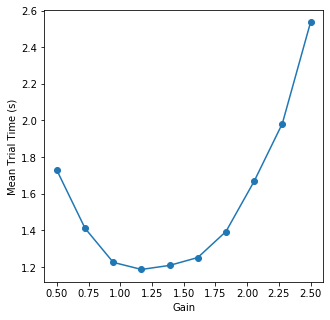

In [97]:
'''Here we define the amount of exponential smoothing used in the decoder (alpha). Values between 0.9 and 0.96 are pretty reasonable. See the paper
'A comparison of intention estimation methods for decoder calibration in intracortical brain-computer interfaces' for an explanation of how velocity Kalman 
filters can be parameterized with a smoothing parameter (alpha), gain parameter (beta, see next section below) and decoding matrix (D). '''

alpha       = 0.94
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)
nSimSteps   = 50000

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(initialTuning, D,alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

### Do a sweep of subspace stabilizer hyperparameters

Find optimal values for $d$ (latent dimensionality), $B$ (number of channels), and threshold.

In [136]:
from stabilizer_utils import Stabilizer, get_FactorAnalysisMap

# general settings:
nSimSteps   = 10000
alpha       = 0.94   # exponential smoothing
beta        = 1.16   # gain
delT        = 0.01   # define the time step (10 ms)
nDelaySteps = 20     # define the simulated user's visual feedback delay (200 ms)
shrinkage   = 0.92

# subspace stabilizer settings:
model_type  = 'FactorAnalysis'

# grid search settings:
d_sweep      = np.arange(2, 10)
B_sweep      = np.arange(10, 101, 10)
thresh_sweep = np.linspace(0.01, 0.10, 10)


#--------------------------------------------------
sweep_scores = np.zeros((len(d_sweep), len(B_sweep), len(thresh_sweep), 3))  # last axis: fully calibrated, nonstationarity, post-stabilization 
newTuning    = simulateTuningShift(initialTuning, PD_shrinkage = shrinkage)   

for i, d in enumerate(d_sweep):
    stab  = Stabilizer(model_type = model_type, n_components = d)
    stab.fit_ref([calNeural])

    Q_ref        = get_FactorAnalysisMap(stab.ref_model)
    calLatent    = (calNeural - calNeural.mean(axis = 0)).dot(Q_ref)
    lr           = LinearRegression(fit_intercept = True).fit(calLatent, calVelocity)

    h      = lr.coef_                                             # map from latent space onto targets
    D_coef = h.dot(Q_ref.T)                                         # compose to get neural --> latent --> output 
    D      = np.hstack([lr.intercept_[:, np.newaxis], D_coef]).T  # add bias terms

    # Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
    D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
    D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])
    
   
    cursorPos, _, decOut, _, targTraj, neural_ref, _, ttt   = simulateBCIFitts(initialTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps) # Simulate BCI performance with matched neural tuning and decoder, and an optimized gain
    #print('Performance with original decoder: ' , np.mean(ttt))
    sweep_scores[i, :, :, 0] = np.mean(ttt)

    cursorPos, _, decOut, _, targTraj, neural_new, _, ttt_new  = simulateBCIFitts(newTuning, D, alpha, beta, nDelaySteps, delT, nSimSteps)   # simulate performnance with old decoder
    #print('Performance with nonstationarity: ', np.mean(ttt_new))
    sweep_scores[i, :, :, 1] = np.mean(ttt_new)

    for j, B in enumerate(B_sweep):
        for k, thresh in enumerate(thresh_sweep):
            
            stab.fit_new([neural_new], B = B, thresh = thresh)
            G_new      = get_FactorAnalysisMap(stab.new_model)
            D_coefnew  = h.dot(G_new.dot(stab.R).T)                                # compose to get neural --> latent --> output 
            D_new      = np.hstack([lr.intercept_[:, np.newaxis], D_coefnew]).T    # add bias terms
            decVec_new = np.hstack([np.ones((neural_new.shape[0], 1)), neural_new]).dot(D_new)

            #Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
            #This will restore the original optimal gain.
            PosErr   = targTraj - cursorPos
            TargDist = np.linalg.norm(PosErr, axis = 1)
            TargDir  = PosErr / TargDist[:, np.newaxis]
            farIdx   = np.where(TargDist > 0.4)[0]
            projVec  = np.sum(np.multiply(decVec_new[farIdx, :], TargDir[farIdx, :]), axis = 1)
            D_new   /= np.mean(projVec)

        
            ttt_recal                = simulateBCIFitts(newTuning, D_new, alpha, beta, nDelaySteps, delT, nSimSteps)[-1] #Simulate BCI performance with the HMM-recalibrated decoder
            sweep_scores[i, j, k, 2] = np.mean(ttt_recal)
        
    print(np.round((i + 1) * 100 / len(d_sweep), 2), '% complete.')
    

12.5 % complete.
25.0 % complete.
37.5 % complete.
50.0 % complete.
62.5 % complete.
75.0 % complete.
87.5 % complete.
100.0 % complete.


Text(0.5, 0.98, 'Average time to target following nonstationarity + stabilization')

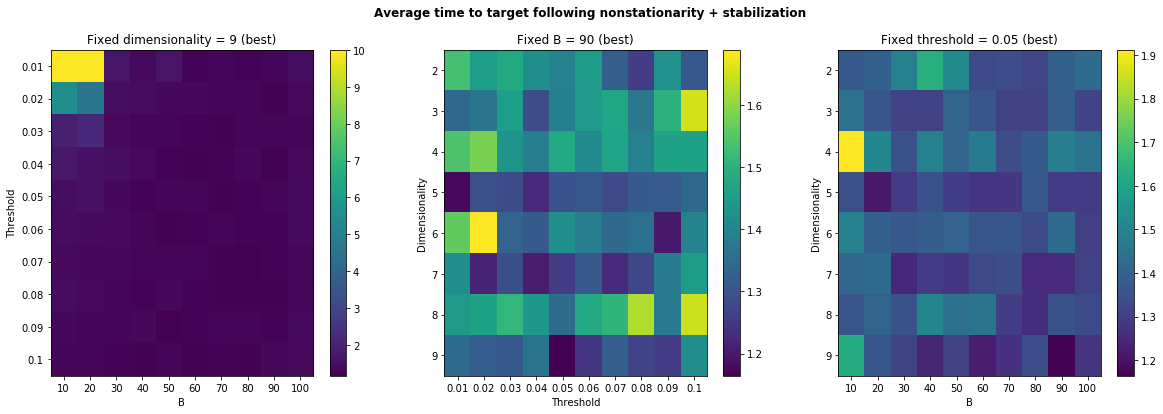

In [138]:
plt_scores = sweep_scores[:, :, :, 2]

arg_d, arg_B, arg_thresh = np.unravel_index(np.argmin(plt_scores), plt_scores.shape)


figSize(6, 20)
plt.subplot(1, 3, 1)
plt.imshow(plt_scores[arg_d, :, :], aspect = 'auto')
plt.title('Fixed dimensionality = ' + str(d_sweep[arg_d]) + ' (best)')
plt.ylabel('Threshold')
plt.yticks(np.arange(len(thresh_sweep)), np.round(thresh_sweep, 3))
plt.xlabel('B')
plt.xticks(np.arange(len(B_sweep)), B_sweep)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(plt_scores[:, arg_B, :], aspect = 'auto')
plt.title('Fixed B = ' + str(B_sweep[arg_B]) + ' (best)')
plt.xlabel('Threshold')
plt.xticks(np.arange(len(thresh_sweep)), np.round(thresh_sweep, 3))
plt.ylabel('Dimensionality')
plt.yticks(np.arange(len(d_sweep)), d_sweep)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(plt_scores[:, :, arg_thresh], aspect = 'auto')
plt.title('Fixed threshold = ' + str(np.round(thresh_sweep[arg_thresh], 3)) + ' (best)')
plt.xlabel('B')
plt.xticks(np.arange(len(B_sweep)), B_sweep)
plt.ylabel('Dimensionality')
plt.yticks(np.arange(len(d_sweep)), d_sweep)
plt.colorbar()

plt.suptitle('Average time to target following nonstationarity + stabilization', fontweight = 'bold')

In [135]:
sweep_scores[arg_d, arg_B, arg_thresh, :]

array([1.20902439, 2.22431818, 1.21950617])